## 3.1.4 Challenge: Model Comparison
### Kevin Hahn  

I used a data set reflecting the housing market in Melbourne, Australia. Because of the numerous methods used to categorize how properties were sold (e.g., sold normally vs. sold at an auction vs. sold without going on the market), I decided to filter the data set and only include houses sold normally.

I built OLS and KNN regression models predicting the sold price using the predictor variables number of bedrooms, number of bathrooms, number of car spaces in garage, distance in miles from Central Business District, size of the land, and year the house was built. Extreme values were removed, including properties with land size larger than 2000 and selling prices over $AUD 4,000,000. A kfolds method (n = 5) was used, splitting the data into test and training groups. With these six features and the kfolds method, OLS predicted an average r-squared value of 0.54 with an average standard deviation of 0.07. KNN predicted an average r-squared value of 0.61 with an average standard deviation of 0.05.

The KNN appeared to be a somewhat better predictor with its higher amount of variance predicted and smaller variability in that average r-squared value. This might support the idea that houses are priced not just based on the number of bedrooms and bathrooms, but also the specific neighborhood or clustered grouping of houses. Based on the r-squared values found, there may not be a definitive winner in terms of modeling OLS vs. KNN with this data set; however, the results suggest KNN might be a slightly better predictor of price, where housing values may depend not just on their distance and selling features, but also their locations and proximity to other similarly-valued houses.

<b>You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. Write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.</b>

Some Key Details about the data

Suburb: Suburb

Address: Address

Rooms: Number of rooms

Price: Price in dollars

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD

In [97]:
import math
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline
import scipy
import sklearn
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
%matplotlib inline
sns.set_style('white')

In [98]:
### Assignment Prep

data_path = ("~/Downloads/Melbourne_housing_extra_data.csv"
            )
housing = pd.read_csv(data_path, delimiter= ',', thousands=',')

housing.head(10)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude
0,Abbotsford,68 Studley St,2.000,h,nan,SS,Jellis,3/09/2016,2.500,3067.000,2.000,1.000,1.000,126.000,nan,nan,Yarra,-37.801,144.996
1,Abbotsford,85 Turner St,2.000,h,1480000.000,S,Biggin,3/12/2016,2.500,3067.000,2.000,1.000,1.000,202.000,nan,nan,Yarra,-37.800,144.998
2,Abbotsford,25 Bloomburg St,2.000,h,1035000.000,S,Biggin,4/02/2016,2.500,3067.000,2.000,1.000,0.000,156.000,79.000,1900.000,Yarra,-37.808,144.993
3,Abbotsford,18/659 Victoria St,3.000,u,nan,VB,Rounds,4/02/2016,2.500,3067.000,3.000,2.000,1.000,0.000,nan,nan,Yarra,-37.811,145.012
4,Abbotsford,5 Charles St,3.000,h,1465000.000,SP,Biggin,4/03/2017,2.500,3067.000,3.000,2.000,0.000,134.000,150.000,1900.000,Yarra,-37.809,144.994
5,Abbotsford,40 Federation La,3.000,h,850000.000,PI,Biggin,4/03/2017,2.500,3067.000,3.000,2.000,1.000,94.000,nan,nan,Yarra,-37.797,144.997
6,Abbotsford,55a Park St,4.000,h,1600000.000,VB,Nelson,4/06/2016,2.500,3067.000,3.000,1.000,2.000,120.000,142.000,2014.000,Yarra,-37.807,144.994
7,Abbotsford,16 Maugie St,4.000,h,nan,SN,Nelson,6/08/2016,2.500,3067.000,3.000,2.000,2.000,400.000,220.000,2006.000,Yarra,-37.797,144.996
8,Abbotsford,53 Turner St,2.000,h,nan,S,Biggin,6/08/2016,2.500,3067.000,4.000,1.000,2.000,201.000,nan,1900.000,Yarra,-37.800,144.997
9,Abbotsford,99 Turner St,2.000,h,nan,S,Collins,6/08/2016,2.500,3067.000,3.000,2.000,1.000,202.000,nan,1900.000,Yarra,-37.800,144.999


In [99]:
new_house = housing[['Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'Price']][housing['Method'] == 'S']
new_house = new_house[new_house['Landsize'] < 2000]
new_house = new_house[new_house['Price'] < 4000000]
new_house = new_house.dropna()
new_house.describe(percentiles=[.0,.10,.25,.50,.75,.90,.95,.98,.99,.995,1.00])

,Distance,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Price
count,3010.000,3010.000,3010.000,3010.000,3010.000,3010.000,3010.000
mean,8.634,2.817,1.502,1.492,373.888,1958.538,1104214.268
std,3.625,0.900,0.670,0.873,295.487,36.867,608471.677
min,1.200,0.000,1.000,0.000,0.000,1850.000,210000.000
0%,1.200,0.000,1.000,0.000,0.000,1850.000,210000.000
10%,3.300,2.000,1.000,1.000,0.000,1900.000,502450.000
25%,5.800,2.000,1.000,1.000,141.000,1930.000,680000.000
50%,8.800,3.000,1.000,1.000,321.500,1960.000,930000.000
75%,11.400,3.000,2.000,2.000,603.000,1990.000,1370000.000
90%,13.600,4.000,2.000,2.000,733.100,2007.000,1900000.000


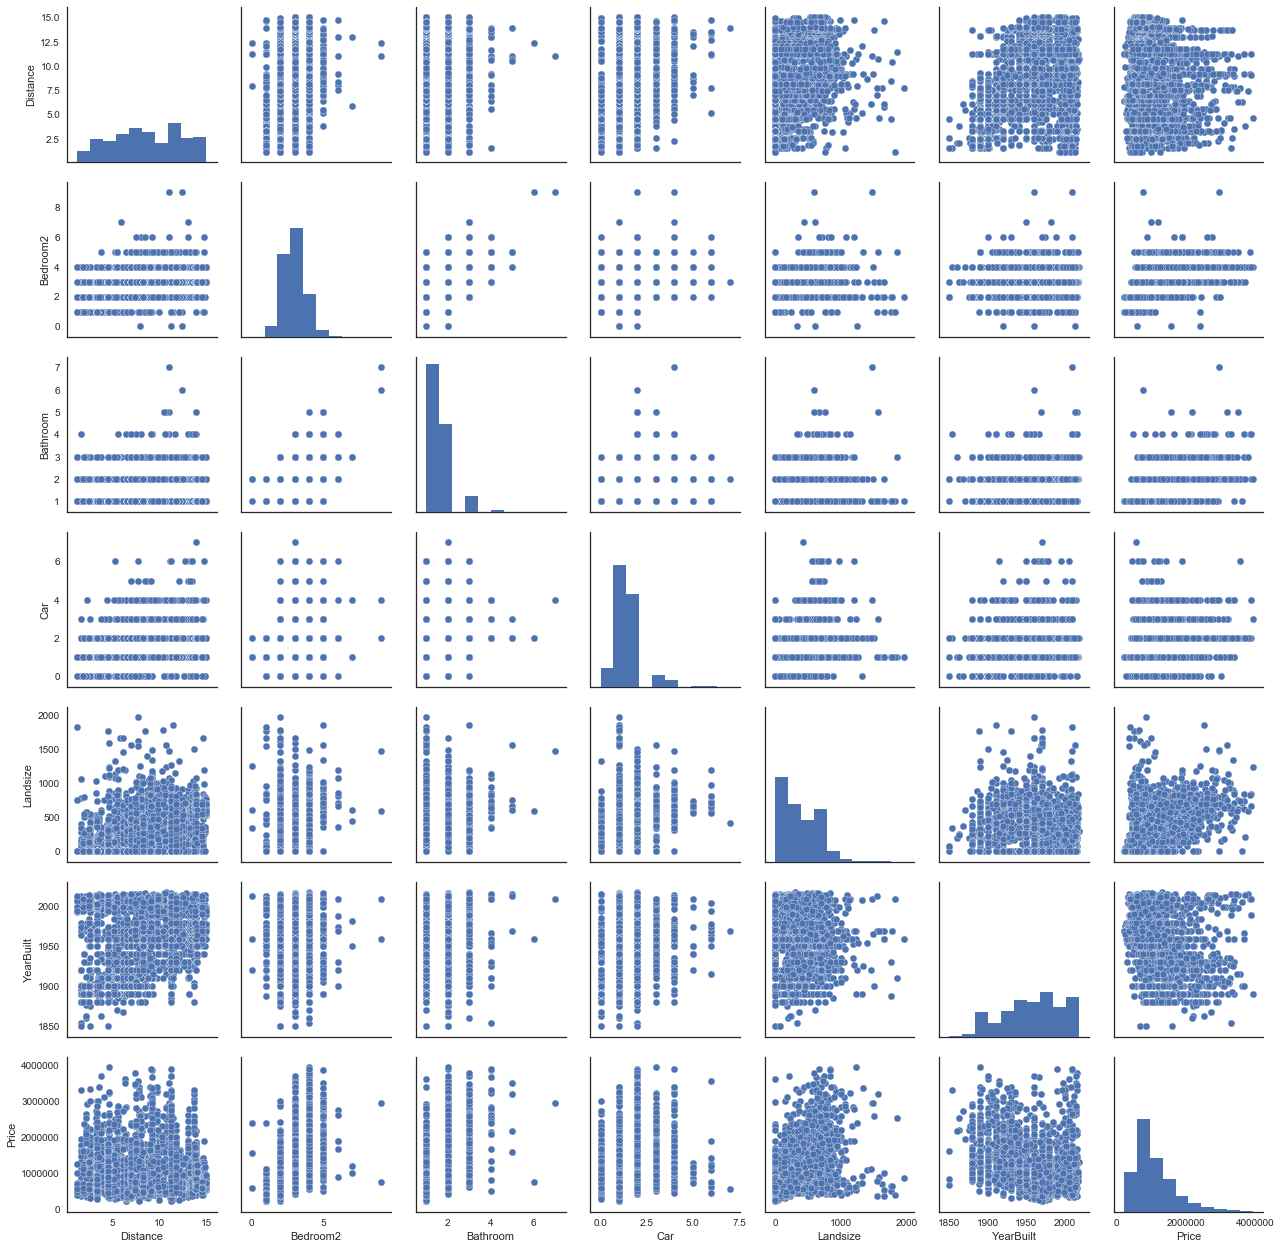

In [100]:
sns.pairplot(new_house) 

# will take log(price)

In [101]:
X = new_house[['Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'YearBuilt']]
y = new_house['Price']

#applying log transformation to y
y = [np.log(x) for x in y]

# import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40) 

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# model = sm.OLS(y_train, x_train, missing='drop')
# predicted = model.fit()
# print(predicted.summary())

#  scoring='mean_squared_error
scored = cross_val_score(regr, X, y, cv=5, scoring='r2')
print(scored.mean(), scored.std())

0.54268505697 0.0740869359558


In [102]:
## New KNN regression model here:

## Increased KNN neighbors considerably 
## used z-scores for loudness/duration
## made weights uniform

## z score transformation -- 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

from scipy import stats

knn_new = KNeighborsRegressor(n_neighbors=25, weights='uniform')

zX = pd.DataFrame({
    'Distance': stats.zscore(X.Distance),
    'Bedroom2': stats.zscore(X.Bedroom2),
    'Bathroom': stats.zscore(X.Bathroom),
    'Car': stats.zscore(X.Car),
    'Landsize': stats.zscore(X.Landsize),
    'YearBuilt': stats.zscore(X.YearBuilt)
})

knn_new.fit(zX, y)

score_new = cross_val_score(knn_new, zX, y, cv=5, scoring='r2')
print(score_new.mean(), score_new.std())

0.606861215236 0.0510205934506


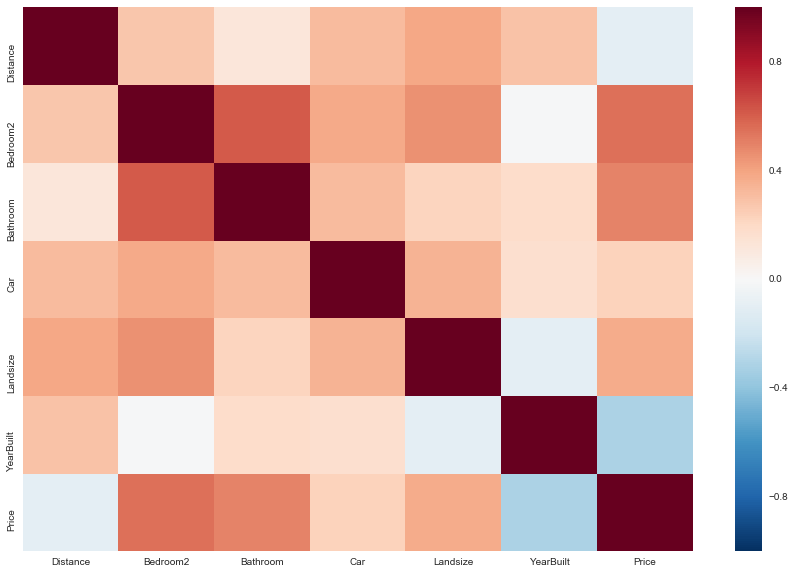

In [103]:
fig, ax = plt.subplots(figsize=(15,10))


corrmap = Z.corr()
sns.heatmap(corrmap)

In [104]:
# import statsmodels.api as sm

# model = sm.OLS(y_train, X_train)
# predicted = model.fit()
# print(predicted.summary())